# Band Diagram

In this tutorial, we will build off of the `holey-wvg-cavity.ipynb` tutorial by considering a smaller, more abstract calculation that we really should have done first. In particular, we compute the band diagram of the infinite periodic waveguide by itself with no defects. This is very similar to the types of calculations that MPB performs, but with a different method that has its own strengths and weaknesses. By analyzing what solutions can propagate in the periodic structure, one gains fundamental insight into the aperiodic structures from `holey-wvg-cavity.ipynb`.

Let us briefly review the problem. In a periodic system of this sort, the eigen-solutions can be expressed in the form of Bloch modes: a periodic Bloch envelope multiplied by a planewave $exp[i(k⋅x−\omega t)]$, where $k$ is the Bloch wavevector. We wish to find the bands $\omega(k)$. In this case, there is only one direction of periodicity, so we only have one wavevector component $k_x$. Moreover, the solutions are periodic functions of this wavevector: for a unit-period structure, $k_x$ and $k_x+2\pi$ are redundant. Also, $k_x$ and $−k_x$ are redundant by time-reversal symmetry, so we only need to look for solutions in the irreducible Brillouin zone from $k_x=0$ to $k_x=\pi$.

Solving for these eigenmodes is very similar to solving for the resonant modes of a cavity. We put in a pulse and analyze the response via Harminv except that our computational cell and boundary conditions are different. In particular, our computational cell is simply the unit cell of the periodicity. The $\epsilon$ function then obeys periodic boundary conditions, but the fields obey Bloch-periodic boundary conditions: the fields at the right side are $exp(ik_x⋅1)$ times the fields at the left side. For each $k_x$, we will do a separate computation to get the frequencies at that $k_x$.

We'll first load our modules:

In [1]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Video

%matplotlib notebook

Using MPI version 3.1, 1 processes


And define our computational cell as follows:

In [2]:
# Some parameters to describe the geometry:
eps = 13  # dielectric constant of waveguide
w = 1.2  # width of waveguide
r = 0.36  # radius of holes

# The cell dimensions
sy = 12  # size of cell in y direction (perpendicular to wvg.)
dpml = 1  # PML thickness (y direction only!)
cell = mp.Vector3(1, sy)

b = mp.Block(size=mp.Vector3(1e20, w, 1e20), material=mp.Medium(epsilon=eps))
c = mp.Cylinder(radius=r)

geometry = [b, c]

resolution = 20

Note that our cell is now size `1` in the x direction, and there is no need for any loops to duplicate the geometry. We just have a single air hole in the unit cell. The PML absorbing boundaries have something new:

In [3]:
pml_layers = [mp.PML(dpml, direction=mp.Y)]

Since our structure is periodic, we don't want any absorbing layers in the $x$ direction: adding `direction=mp.Y` just specifies PML layers on the $y$ boundaries.

As before, our source will be a Gaussian pulse from an $H_z$ point source:

In [4]:
fcen = 0.25  # pulse center frequency
df = 1.5  # pulse freq. width: large df = short impulse

s = [
    mp.Source(
        src=mp.GaussianSource(fcen, fwidth=df),
        component=mp.Hz,
        center=mp.Vector3(0.1234, 0),
    )
]

Notice that we put our source at $(0.1234,0)$. The $x$ coordinate is random, to help ensure that the source will couple to an arbitrary mode, but the $y$ coordinate is 0. This means that we will only be looking at $H_z$-polarized odd-symmetry modes (recalling the pseudovector subtlety discussed above). As usual, we will exploit this via:

In [5]:
sym = [mp.Mirror(direction=mp.Y, phase=-1)]

Note that, regardless of the source, we don't have an $X$ symmetry plane because this symmetry is broken by our boundary condition for $0<k_x<\pi$.

Let's set up our simulation and visualize the domain:

-----------
Initializing structure...
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     cylinder, center = (0,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)


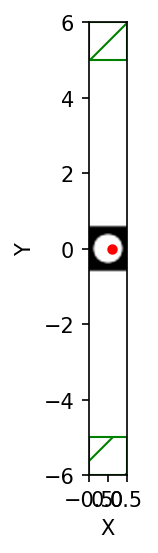

In [6]:
sim = mp.Simulation(
    cell_size=cell,
    geometry=geometry,
    boundary_layers=pml_layers,
    sources=s,
    symmetries=sym,
    resolution=resolution,
)
f = plt.figure(dpi=150)
sim.plot2D(ax=f.gca())
plt.show()

Now, there are two ways to proceed. First, we could set the value of $k$ via the `k_point` variable, and then use `until_after_sources` with Harminv just as we did to calculate a resonant mode:

In [7]:
kx = 0.4
sim.k_point = mp.Vector3(kx)

sim.run(
    mp.after_sources(mp.Harminv(mp.Hz, mp.Vector3(0.1234), fcen, df)),
    until_after_sources=300,
)

harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.3050132495988499, 3.480691775115153e-06, -43815.03294539187, 0.011878313829683136, -0.01179628264240186-0.0013935764266843182i, 5.295036558380241e-07+0.0i
harminv0:, 0.43960436531181446, -2.7363657356159734e-06, 80326.31741985629, 0.01745119452862526, 0.017126214985327293-0.0033521561348289074i, 9.312403773661967e-08+0.0i
harminv0:, 0.5005873843994147, -0.0009565526575684324, 261.6622202858719, 0.00018410949058675333, -0.00011025456283318074-0.00014744570491736274i, 1.242711680938466e-05+0.0i
harminv0:, 0.6404729374549927, -0.005167317620050075, 61.97344391699944, 0.0031051734641799815, 0.0007710721023072853-0.0030079145692141806i, 3.514904299909929e-05+0.0i
harminv0:, 0.700226243241067, -0.0037510897788062153, 93.3363748313049, 0.004369347983945716, -5.4869994286284585e-05+0.0043690034434110386i, 1.3205854700252928e-05+0.0i
harminv0:, 0.762852889565266, -0.006722784235381431, 56.73638055721298, 0.03169553968207

which gives us the frequencies at a single $k=0.4⋅2\pi x̂$. Note that, in Meep, $k$ is specified as a vector in Cartesian coordinates, with units of $2\pi$/distance. This is different from MPB, which uses the basis of the _reciprocal lattice_ vectors. However, this only gives us one $k$. Instead, there is a built-in function which takes as input a time to run after the sources finish, like the 300 above, and a list of $k$ points:

In [8]:
%%capture
sim.restart_fields()
k_interp = 19
kpts = mp.interpolate(k_interp, [mp.Vector3(0), mp.Vector3(0.5)])
all_freqs = sim.run_k_points(300, kpts)

Here, we have used Meep's built-in `interpolate` function to interpolate a set of 19 $k$ points between $k=0$ and $k=0.5⋅2\pi x̂$ , to cover the irreducible Brillouin zone. This function automatically runs Harminv, using the frequency range and location taken from the Gaussian source in the sources list. It returns the calculated modes as a list of lists.

Plotting the real parts of $\omega$, where the light cone $\omega > ck$ is shaded gray, we find:

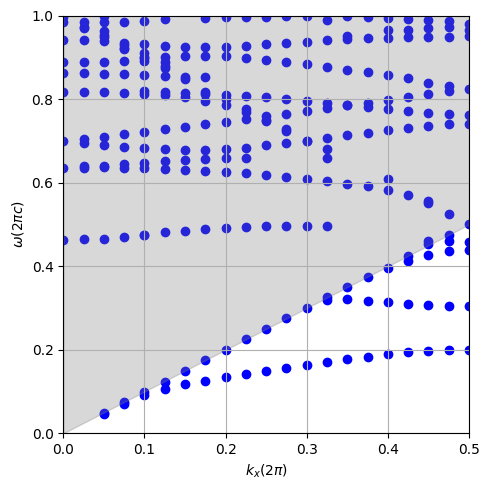

In [9]:
kx = [k.x for k in kpts]
fig = plt.figure(dpi=100, figsize=(5, 5))
ax = plt.subplot(111)
for i in range(len(all_freqs)):
    for ii in range(len(all_freqs[i])):
        plt.scatter(kx[i], np.real(all_freqs[i][ii]), color="b")

ax.fill_between(kx, kx, 1.0, interpolate=True, color="gray", alpha=0.3)
plt.xlim(0, 0.5)
plt.ylim(0, 1)
plt.grid(True)
plt.xlabel("$k_x(2\pi)$")
plt.ylabel("$\omega(2\pi c)$")
plt.tight_layout()
plt.show()

The gray shaded region is the light cone, $\omega>ck_x$, which is the region corresponding to modes that are extended in the air surrounding the waveguide. Below the light cone, we see several discrete guided bands, which must have field patterns localized to the vicinity of the waveguide. The imaginary part of $\omega$ for bands below the light cone is very small, due to either numerical error or the finite computational cell size. Some tiny portion of the guided mode overlaps the PML. Note the band gap between the first and second guided mode, from about 0.2 to 0.3.

Inside the light cone, we also see several discrete bands. These are leaky modes, or resonances, which have some intrinsic lifetime/loss because they couple with radiating states inside the light cone, which is reflected in the imaginary parts of their $\omega$. Twice the imaginary part of $\omega$ is the energy loss rate per unit time; for a waveguide, it is more conventional to report loss per unit distance; to get this you would divide the loss per unit time by the group velocity $|d\omega/dk_x| = |slope|$. Harminv only identifies leaky modes that have a substantial lifetime. The default threshold is a lifetime, or $Q$, of 50 periods.

Computing band diagrams, especially for leaky modes, with a time-domain program like Meep involves several subtleties. For example, the accuracy of Harminv will go down if we specify too large a `df` (too narrow a source), because the increased number of modes makes the signal-processing more ill-conditioned. Sometimes, Harminv will report a spurious mode, which will appear as an isolated dot on the plot. Second, we sometimes have to be careful with modes and especially the imaginary parts to make sure they aren't an artifact of the cell being too small, or the signal-processing error being too large (either because the run is too short or because the bandwidth being searched is too large). Third, currently Meep doesn't attempt to "connect the dots" for the bands — the frequencies are printed in increasing order, but since modes disappear when their losses become too large this means that a single band may be split across several columns.

For example, there seem to be some bands that run right along the edge of the light cone. These are not leaky modes, but are artifacts of the fact that PML boundaries do not absorb well for light that is travelling parallel to the boundary, corresponding to extended modes at the boundary of the light cone. Below, we will see that these modes are not localized to the waveguide.

It is usually a good idea to examine the field patterns for any modes that you are particularly interested in. That is, re-run the simulation with a narrow-bandwidth source, at the particular ω and k you want, and output the field patterns just as we did for the resonant-cavity modes. We'll do that for several modes below:

* $k_x=0.4, \omega=0.1896$ guided mode
* $k_x=0.4, \omega=0.3175$ guided mode
* $k_x=0.1, \omega=0.4811−0.0017i$ leaky mode
* $k_x=0.3, \omega=0.8838−0.0018i$ leaky mode
* $k_x=0.25, \omega=0.2506$ light-cone (extended) mode

First, we'll wrap the routine in a function:

In [10]:
def run_sim(kx, omega, filename):
    s = [
        mp.Source(
            src=mp.GaussianSource(omega, fwidth=0.01),
            component=mp.Hz,
            center=mp.Vector3(0.1234, 0),
        )
    ]
    sim = mp.Simulation(
        cell_size=cell,
        geometry=geometry,
        boundary_layers=pml_layers,
        sources=s,
        symmetries=sym,
        k_point=mp.Vector3(kx),
        resolution=resolution,
    )
    f = plt.figure(dpi=100)
    animate = mp.Animate2D(fields=mp.Hz, f=f, normalize=True, realtime=False)
    sim.run(mp.at_every(5, animate), until_after_sources=1)
    animate.to_mp4(10, filename)
    plt.close()

-----------
Initializing structure...
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     cylinder, center = (0,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
Meep: using complex fields.
Normalizing field data...
run 0 finished at t = 1001.0 (40040 timesteps)
Generating MP4...
-----------
Initializing structure...
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     cylinder, center = (0,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
Meep: using complex fields.
Normalizing field data...
run 0 finished at t = 1001.0 (40040 timesteps)
Generating MP4...
-----------
Initializing structure...
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     cylinder, center = (0,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
Meep: using complex fields.
Meep progress: 929.575/1001.0 = 92.9% done in 4.0s, 0.3s to

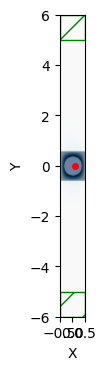

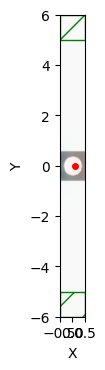

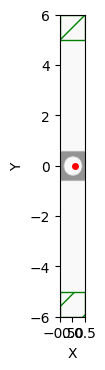

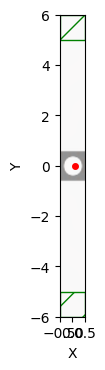

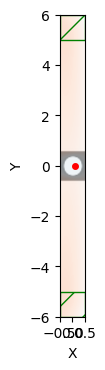

In [15]:
kx = [0.4, 0.4, 0.1, 0.3, 0.25]
omega = [0.1896, 0.3175, 0.4811, 0.8838, 0.2506]
filename = [
    "media/holey-wvg-bands-{}-{}.mp4".format(k, om) for (k, om) in zip(kx, omega)
]
for (k, om, fn) in zip(kx, omega, filename):
    run_sim(*[k, om, fn])

In [19]:
import IPython

for i in range(len(filename)):
    IPython.display.display(IPython.display.Video(filename[i]))

* From the top, the first two pictures show the first two guided bands underneath the light cone at $k_x=0.4$. Note that the second guided band is propagating to the left, which is due to its negative slope (note, however, that there is a corresponding right-propagating mode at $k_x=−0.4$). Note that they are strongly (exponentially) localized to the waveguide, as they should be.

* The next mode is the first leaky mode at $k_x=0.1$. As $k_x$ goes to zero, in fact, this mode actually becomes lossless, a peculiarity of symmetry related to an effect demonstrated in Phys. Rev. B. 63, 125107, 2001. However, at this non-zero $k_x$, the radiation loss is clearly visible.

* The next mode is one of the many higher-order leaky modes visible in the band diagram; we arbitrarily chose the backwards-propagating mode at $k_x=0.3$, $\omega=0.8838−0.0018i$ to plot. As can be seen from the field pattern, this mode has a very short wavelength in the material. This is short enough that it is worth checking how big the error introduced by the finite resolution is. By doubling the resolution to 40 pixels/unit, we found that this mode has shifted to $\omegaω=0.8996−0.0021i$, or about a 2% error at the lower resolution.

* Finally, we show one of the modes right along the edge of the light cone, at $k_x=0.25$, $\omega=0.2506$. This mode is clearly not localized to the waveguide, and is just propagating through the air parallel to the waveguide — i.e. it is really part of the continuum of extended modes and its discreteness is an artifact of the finite cell and imperfect boundary conditions. For light propagating completely parallel to the boundary, PML is not very effective, so the imaginary part of ω is only -0.0008 for this field.